In [1]:
import mne
import numpy as np
import matplotlib.pyplot as plt
#mne.viz.set_3d_backend("notebook")

In [2]:
# Authors: Alexandre Gramfort <alexandre.gramfort@inria.fr>
#          Joan Massich <mailsik@gmail.com>
#          Eric Larson <larson.eric.d@gmail.com>
#
# License: BSD-3-Clause

import os.path as op
import numpy as np

import mne
from mne.datasets import eegbci
from mne.datasets import fetch_fsaverage

# Download fsaverage files
fs_dir = fetch_fsaverage(verbose=True)
subjects_dir = op.dirname(fs_dir)

# The files live in:
subject = 'fsaverage'
trans = 'fsaverage'  # MNE has a built-in fsaverage transformation
src = op.join(fs_dir, 'bem', 'fsaverage-ico-5-src.fif')
bem = op.join(fs_dir, 'bem', 'fsaverage-5120-5120-5120-bem-sol.fif')

0 files missing from root.txt in /home/williamtheodor/anaconda3/lib/python3.8/site-packages/nibabel/freesurfer/subjects
0 files missing from bem.txt in /home/williamtheodor/anaconda3/lib/python3.8/site-packages/nibabel/freesurfer/subjects/fsaverage


In [3]:
FILE = 'S001R10.edf'

raw = mne.io.read_raw_edf(FILE, verbose=False, preload=True)
mne.datasets.eegbci.standardize(raw)  # set channel names
montage=mne.channels.make_standard_montage('standard_1020')
raw = raw.set_montage(montage); # set montage

In [4]:
fwd = mne.make_forward_solution(raw.info, trans=trans, src=src, bem=bem,  meg=False, eeg=True, verbose=False)
fwd = mne.convert_forward_solution(fwd, force_fixed=True, verbose=False)

In [5]:
163842*2

327684

In [6]:
fwd['src'][0]

{'id': 101,
 'type': 'surf',
 'np': 163842,
 'ntri': 327680,
 'coord_frame': 4 (FIFFV_COORD_HEAD),
 'rr': array([[-0.03862072,  0.01661226,  0.10499121],
        [-0.01817344, -0.03212844,  0.10247761],
        [-0.01327658,  0.02615479,  0.0872164 ],
        ...,
        [-0.03604393,  0.00699157,  0.01683981],
        [-0.03614374,  0.00686359,  0.01749217],
        [-0.03694333,  0.00660879,  0.01816823]]),
 'nn': array([[-0.74110275, -0.51734799,  0.42792249],
        [-0.20988682, -0.89194454,  0.40047775],
        [ 0.78855397, -0.29757831, -0.53817261],
        ...,
        [-0.77590807, -0.51805697, -0.35997743],
        [-0.30526371, -0.81824171, -0.48712926],
        [ 0.15532299, -0.78932634, -0.59400263]]),
 'tris': array([[     0,  40964,  40962],
        [     0,  40962,  40965],
        [     0,  40965,  40967],
        ...,
        [163841, 160926,  39990],
        [163113, 160926, 163841],
        [163113,     11, 160926]], dtype=int32),
 'nuse': 10242,
 'inuse': array

In [7]:
fwd['src'][0]['tris'].shape

(327680, 3)

In [8]:
def get_vertex_locations(fwd):
    vertex_locations = []
    for s, h in zip(fwd["src"], ("lh", "rh")):
        vertex_locations.append(s["rr"])
    
    n_vertices_lh = fwd['src'][0]['np']
    n_vertices_rh = fwd['src'][0]['np']
    vertex_locations = np.array(vertex_locations).reshape(n_vertices_lh+n_vertices_rh, 3)

    return vertex_locations

def get_source_locations(fwd):
    return fwd['source_rr']


vertex_locations = get_vertex_locations(fwd)
source_locations = get_source_locations(fwd)

In [9]:
L = fwd['sol']['data']
L.shape

(64, 20484)

In [10]:
raw.info

<Info | 8 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
>

In [11]:
F = raw.get_data()[:, :160] # first second of data
F.shape

(64, 160)

In [12]:
C = L.T@F
C.shape

(20484, 160)

In [13]:
C[0].shape

(160,)

In [14]:
fwd.keys()

dict_keys(['sol', 'source_ori', 'nsource', 'coord_frame', 'sol_grad', 'nchan', '_orig_source_ori', '_orig_sol', '_orig_sol_grad', 'info', 'src', 'source_nn', 'source_rr', 'surf_ori', 'mri_head_t'])

In [15]:
fwd['src'][0]['rr'].shape

(163842, 3)

In [16]:
fwd['src'][0]['tris']

array([[     0,  40964,  40962],
       [     0,  40962,  40965],
       [     0,  40965,  40967],
       ...,
       [163841, 160926,  39990],
       [163113, 160926, 163841],
       [163113,     11, 160926]], dtype=int32)

In [17]:
from tqdm import tqdm

def get_mesh_neightbour_dict(mesh_data):
    neightbours_dict = {}
    for i in tqdm(range(20000)):
        neightbours = mesh_data[np.any(mesh_data == i, axis=1)].flatten()
        neightbours = np.unique(neightbours[neightbours != i])
        neightbours_dict[i] = neightbours
    return neightbours_dict

get_mesh_neightbour_dict(fwd['src'][0]['tris'])

100%|██████████| 20000/20000 [01:41<00:00, 197.72it/s]


{0: array([40962, 40964, 40965, 40967, 40969], dtype=int32),
 1: array([ 40989,  40991,  40992, 150713, 150714], dtype=int32),
 2: array([ 40994,  40996, 151443, 151444, 152901], dtype=int32),
 3: array([ 40972,  40974,  40975,  40977, 149982], dtype=int32),
 4: array([ 40979,  40981,  40982, 149252, 149253], dtype=int32),
 5: array([ 40984,  40986,  40987, 149983, 149984], dtype=int32),
 6: array([ 41006,  41008, 156550, 156551, 158008], dtype=int32),
 7: array([ 41009,  41011, 158009, 158010, 159467], dtype=int32),
 8: array([ 40997,  40999, 152902, 152903, 159468], dtype=int32),
 9: array([ 41000,  41002, 153632, 153633, 155090], dtype=int32),
 10: array([ 41003,  41005, 155091, 155092, 156549], dtype=int32),
 11: array([160925, 160926, 161655, 162384, 163113], dtype=int32),
 12: array([ 41012,  41014,  41023,  41025, 144362, 144363], dtype=int32),
 13: array([ 41062,  41064, 146071, 146072, 149496, 149739], dtype=int32),
 14: array([ 41015,  41017,  41019,  41042, 144606, 145339], 

In [18]:
mne.datasets.fetch_aparc_sub_parcellation(subjects_dir=subjects_dir, verbose=True)

#labels = mne.read_labels_from_annot('fsaverage', 'HCPMMP1', 'lh', subjects_dir=subjects_dir)
labels = mne.read_labels_from_annot(subject)

Reading labels from parcellation...
   read 35 labels from /home/williamtheodor/anaconda3/lib/python3.8/site-packages/nibabel/freesurfer/subjects/fsaverage/label/lh.aparc.annot
   read 34 labels from /home/williamtheodor/anaconda3/lib/python3.8/site-packages/nibabel/freesurfer/subjects/fsaverage/label/rh.aparc.annot


In [19]:
print(vertex_locations.shape)
print(source_locations.shape)

(327684, 3)
(20484, 3)


In [20]:
#TODO make mask dict based on labels
import matplotlib

tri = matplotlib.tri.Triangulation(vertex_locations[:,0], vertex_locations[:,1], triangles=fwd['src'][0]['tris'], mask=None)

/tmp/ipykernel_12682/1918743160.py:18: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax1.dist = 8


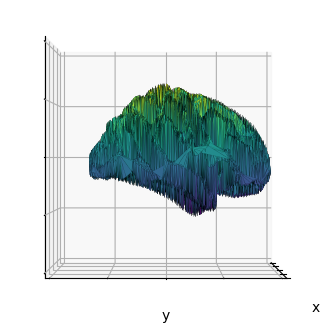

In [21]:
fig = plt.figure(figsize=(18,6))

ax1 = fig.add_subplot(1, 4, 1, projection='3d')

ax1.set_xticklabels([])
ax1.set_yticklabels([])
ax1.set_zticklabels([])

ax1.set_xlim(-0.1, 0.1)
ax1.set_ylim(-0.1, 0.1)
ax1.set_zlim(-0.05, 0.15)
ax1.set_box_aspect([1,1,1])

ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.view_init(0, 0)

ax1.dist = 8
ax1.xaxis.labelpad = -2
ax1.yaxis.labelpad = -5




collec = ax1.plot_trisurf(*source_locations.T, linewidth=0.1, shade=False, cmap='viridis', antialiased=True, edgecolor=(0,0,0,0.5))

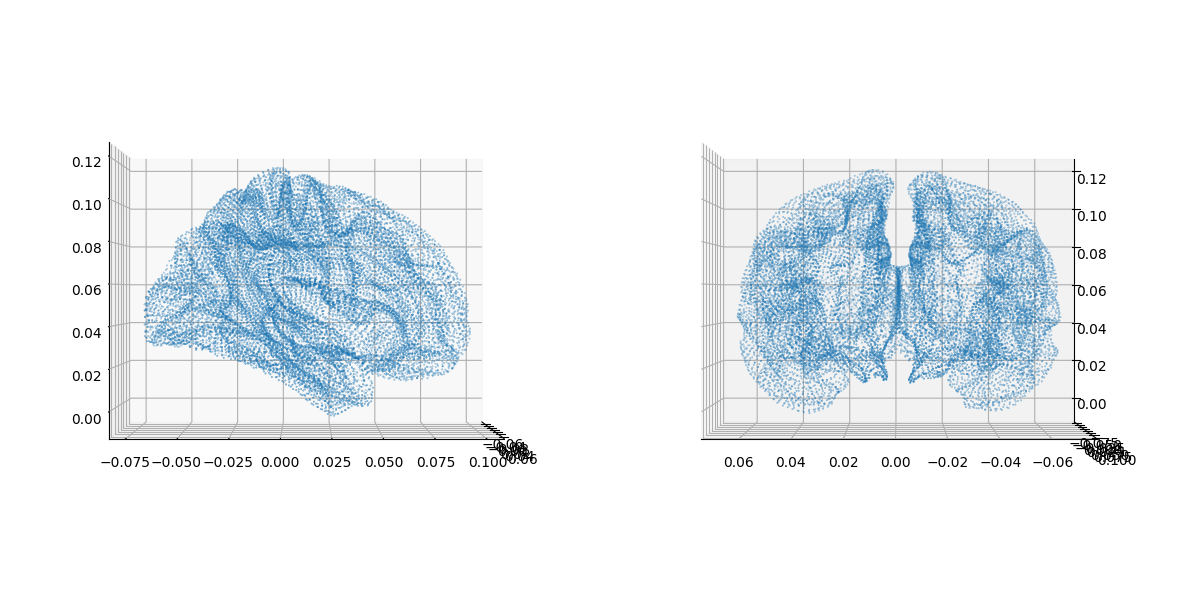

In [22]:
fig = plt.figure(figsize=(12,8))

n_plots = 2
views = [(0,0), (0,90)]

colormap = [plt.get_cmap('tab20')(x) for x in np.linspace(0,1,20)]

for plot_idx in range(n_plots):
    
    ax = fig.add_subplot(1, n_plots, plot_idx+1, projection='3d')
    ax.scatter3D(source_locations[:,0], source_locations[:,1], source_locations[:,2], s=.1)

    ax.view_init(views[plot_idx][0], views[plot_idx][1])

plt.tight_layout()
plt.show()

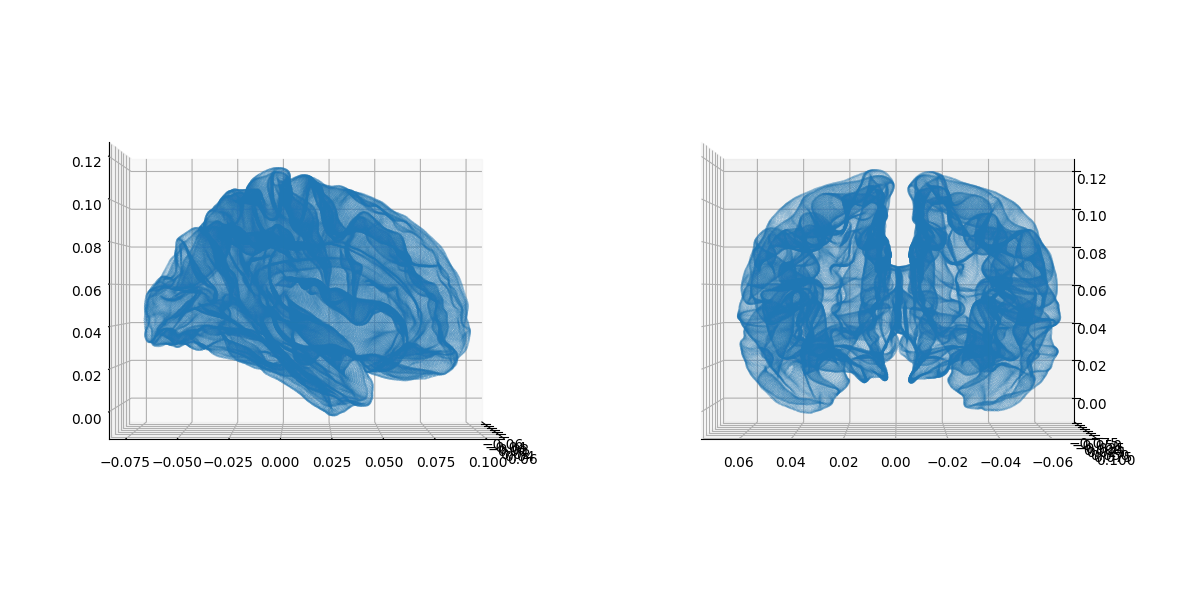

In [23]:
fig = plt.figure(figsize=(12,8))

n_plots = 2
views = [(0,0), (0,90)]

colormap = [plt.get_cmap('tab20')(x) for x in np.linspace(0,1,20)]

for plot_idx in range(n_plots):
    
    ax = fig.add_subplot(1, n_plots, plot_idx+1, projection='3d')
    ax.scatter3D(vertex_locations[:,0], vertex_locations[:,1], vertex_locations[:,2], s=.01)
    for idx, label in enumerate(labels): 
        region_locations = vertex_locations[label.vertices]
        #ax.scatter3D(region_locations[:,0], region_locations[:,1], region_locations[:,2], s=.5, color=colormap[idx%20], label=label.name)
        #ax.scatter3D(region_locations[:,0], region_locations[:,1], region_locations[:,2], s=.1)#, color='blue', label=label.name)

    #ax.set_xlim(-.08, .07)
    #ax.set_ylim(-.1, -.1)
    #ax.set_zlim(-.01, -.1)

    ax.view_init(views[plot_idx][0], views[plot_idx][1])

plt.tight_layout()
plt.show()


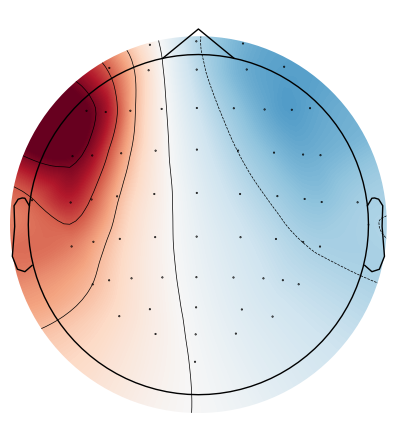

In [24]:
fig, ax = plt.subplots(1, 1)
im, _ = mne.viz.plot_topomap(L.T[9], raw.info, axes=ax, show=False)

Effective window size : 1.600 (s)


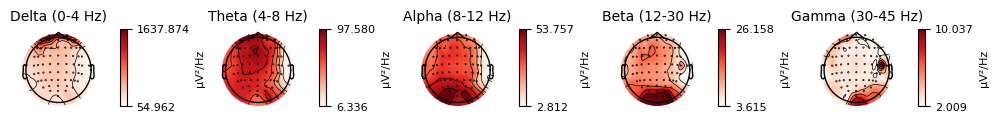

In [25]:
raw.compute_psd().plot_topomap();

Using surface: /home/williamtheodor/anaconda3/lib/python3.8/site-packages/nibabel/freesurfer/subjects/fsaverage/bem/inner_skull.surf
Using surface: /home/williamtheodor/anaconda3/lib/python3.8/site-packages/nibabel/freesurfer/subjects/fsaverage/bem/outer_skull.surf
Using surface: /home/williamtheodor/anaconda3/lib/python3.8/site-packages/nibabel/freesurfer/subjects/fsaverage/bem/outer_skin.surf


/home/williamtheodor/anaconda3/envs/XAI/lib/python3.10/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


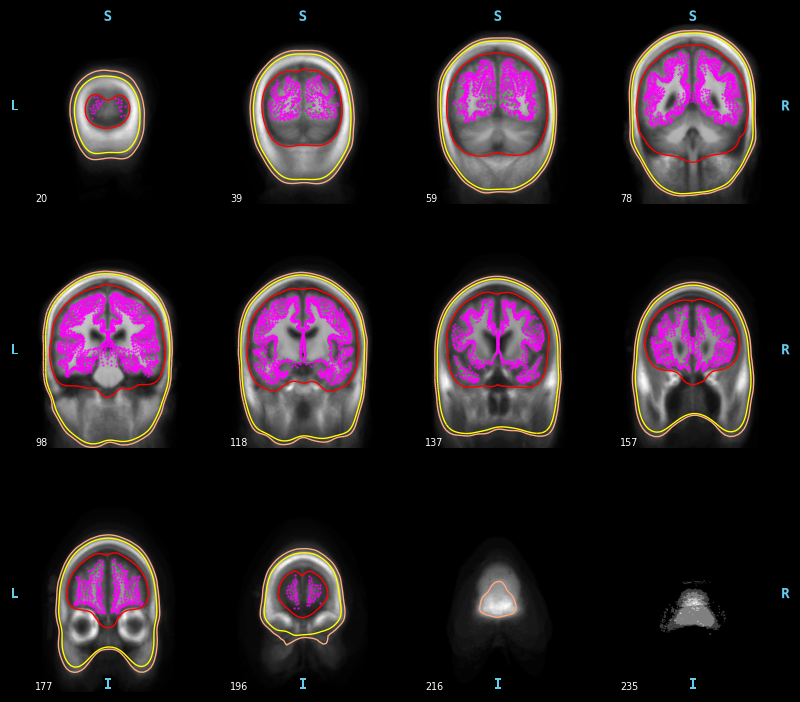

In [26]:
src = mne.setup_source_space(subject, spacing='oct6',
                             subjects_dir=subjects_dir, add_dist=False, verbose=False)

mne.viz.plot_bem(subject=subject, subjects_dir=subjects_dir,
                 brain_surfaces='white', src=src, orientation='coronal')

In [27]:
mne.SourceEstimate(raw.get_data(), [0, 1], 0, 1)

ValueError: diff requires input that is at least one dimensional